# DS 504 Big data analytics project2



In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os, random

JoinResPath = "./data/JoinResults/"
Ilist = os.listdir(JoinResPath)

def readJR(Id=None,LEAST = 100):
    #least: threshold for number of trajectory points
    Iid = (str(Id) if type(Id)==int else Id) if Id else random.choice(Ilist)
    with open(JoinResPath+Iid,"rb") as f:
        res = []
        for i in f:
            res.append(i.strip().split(","))
    df = pd.DataFrame(res[1:])
    if not Id and not len(df)>LEAST:
        return readJR(None,LEAST)
    df[2], df[3] = df[2].astype(float), df[3].astype(float) 
    return (int(res[0][0]),float(res[0][1]),float(res[0][2])),df
    
def plotJR(c,df):
    plt.scatter(df[2],df[3],color="b",s=2)
    plt.scatter(float(c[1]),float(c[2]),color="r",s=30)
    xl,xu,yl,yu=df[2].min(),df[2].max(),df[3].min(),df[3].max()
    xrng,yrng = xu-xl or 0.001,yu-yl or 0.001
    plt.xlim([xl-.1*xrng,xu+.1*xrng])
    plt.ylim([yl-.1*yrng,yu+.1*yrng])
    plt.title("Intersection:%d, # of points:%d"%(c[0],len(df)))

((3420, 22.5431178, 114.0761194),
 (22.541121, 114.07411999999999, 22.545116, 114.07811700000001))

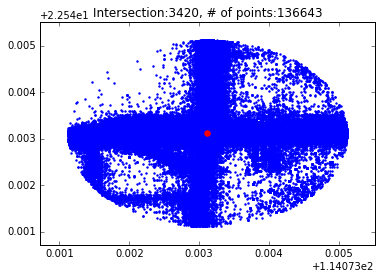

In [17]:
#329946
center,points = readJR(LEAST=30)
plotJR(center,points)
(center[0],center[2],center[1]),(points[3].min(),points[2].min(),points[3].max(),points[2].max())

In [18]:
points.sort_values(by=[1])

,0,1,2,3
9474,28002,00:00:00,114.075218,22.542784
9475,28002,00:00:01,114.075371,22.542700
116238,27274,00:00:03,114.077682,22.543133
53222,30281,00:00:04,114.076149,22.543200
19746,34183,00:00:04,114.076134,22.542883
1277,22994,00:00:05,114.076134,22.542549
52867,29952,00:00:07,114.076050,22.543133
131609,24080,00:00:08,114.074898,22.543100
128661,23409,00:00:09,114.076530,22.545017
67253,35780,00:00:10,114.076836,22.544533


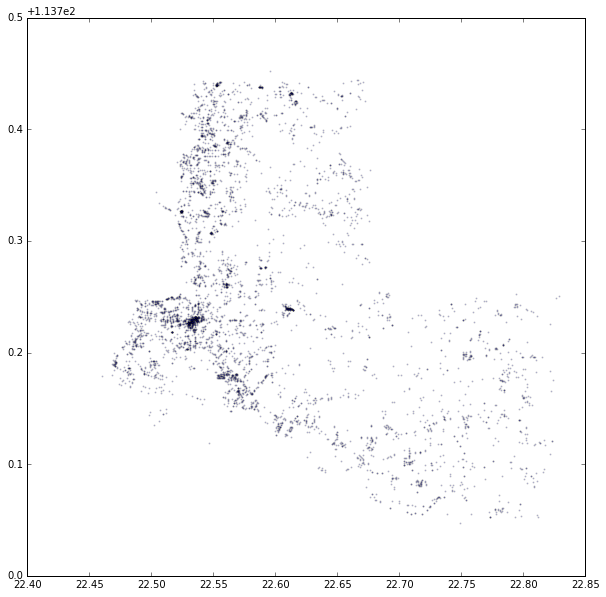

In [5]:
with open("./data/intersections","rb") as f:
    res=[]
    for i in f:
        res.append(i.strip().split(","))
df = pd.DataFrame(res)
df[0],df[1],df[2] = df[0].astype(int),df[1].astype(float),df[2].astype(float)
plt.figure(figsize=(10,10))
plt.scatter(df[2],df[1],s=1,alpha=0.2)
plt.show()